Add Lineup to Model

    - Last time we scraped individual batter data for the 7300+ players who have appeared in a starting lineup between 1970 and 2022.
    - We then processed the data to get statistics about the trailing performance of each of the players before each game in which they started.
    - Using this, we were able to get features related to each player that could be used to predict each game. We then averaged across the lineup in several different ways to come up with a variety of lineup related statistics.
    - Now, we will add these features to the model and see how much improvement we get

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df = pd.read_csv('df_bp9.csv', low_memory=False)

BEGIN MODELING

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1901) & (df.season<=2000) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2001) & (df.season<=2020)]
df_test = df[df.season>=2021]
df_test_val = df[df.season>=2019]

In [4]:
df.shape

(132040, 1235)

In [5]:
hv_mean = df_train.home_victory.mean()
hv_mean

0.5405885434635387

Let's add in some lineup features

In [6]:
target = 'home_victory'

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [7]:
def try_features(feat_set, max_depth=2):
    target = 'home_victory'
    X_train = df_train.loc[:,feat_set]
    X_valid = df_valid.loc[:,feat_set]
    X_test = df_test.loc[:,feat_set]



    lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)
    lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds_lgbm_test = lgbm1.predict_proba(X_test)[:,1]
    ll_test = log_loss(y_test, preds_lgbm_test)

    print(f'\nVegas probs: {log_loss(y_test,df_test.implied_prob_h_mid)} on test')
    print(f'model probs: {ll_test} on test')

    print(f'\nDifference: {ll_test - log_loss(y_test,df_test.implied_prob_h_mid)} on test')

    sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
    sv_lgbm = pd.DataFrame(sv_lgbm)
    sv_lgbm.columns = list(X_test.columns)+['Intercept']
    sv_vec = sv_lgbm.abs().mean().sort_values(ascending=False)
    print('\nAvg Shap Vals')
    
    print(sv_vec)
    out_dict={}
    out_dict['ll_test'] = ll_test
    out_dict['model'] = lgbm1
    out_dict['shap_val_avgs'] = sv_vec
    out_dict['preds_test'] = preds_lgbm_test
    return(out_dict)

First, let's revisit our best model from our last modeling session

In [8]:
features0 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v']

In [9]:
d0 = try_features(features0)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[646]	valid_0's binary_logloss: 0.678925

Vegas probs: 0.6675629431340582 on test
model probs: 0.6728983833576829 on test

Difference: 0.0053354402236247545 on test

Avg Shap Vals
Intercept               0.165133
Strt_SO_perc_10_v       0.123603
Strt_SO_perc_10_h       0.077128
Strt_WHIP_35_v          0.067719
OBP_162_h               0.061638
SLG_162_h               0.053926
Strt_WHIP_35_h          0.053013
OBP_162_v               0.051137
SLG_162_v               0.050572
Bpen_SO_perc_75_v       0.048013
Strt_TB_BB_perc_35_h    0.035477
Strt_H_BB_perc_35_h     0.029470
Strt_TB_BB_perc_35_v    0.026005
Bpen_TB_BB_perc_10_v    0.017387
Bpen_SO_perc_75_h       0.016524
Bpen_WHIP_75_h          0.014822
Bpen_SO_perc_35_v       0.013476
Bpen_TB_BB_perc_75_v    0.012695
Bpen_H_BB_perc_75_h     0.012529
Bpen_SO_perc_10_v       0.012388
Bpen_TB_BB_perc_35_v    0.010661
Bpen_SO_perc_35_h       0.00783

In [10]:
f_lineup_a = [
            'lineup9_OBP_162_h','lineup9_OBP_162_v',
            'lineup9_SLG_162_h','lineup9_SLG_162_v',
]

In [11]:
features1 = features0 + f_lineup_a
d1 = try_features(features1)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[708]	valid_0's binary_logloss: 0.678051

Vegas probs: 0.6675629431340582 on test
model probs: 0.6714753310080693 on test

Difference: 0.003912387874011158 on test

Avg Shap Vals
Intercept               0.165503
Strt_SO_perc_10_v       0.114048
Strt_SO_perc_10_h       0.075429
Strt_WHIP_35_v          0.061881
lineup9_SLG_162_v       0.051015
lineup9_SLG_162_h       0.048136
Strt_WHIP_35_h          0.046712
lineup9_OBP_162_h       0.041517
OBP_162_h               0.041387
Bpen_SO_perc_75_v       0.040343
OBP_162_v               0.037955
Strt_TB_BB_perc_35_h    0.036101
SLG_162_h               0.030154
SLG_162_v               0.029996
Strt_TB_BB_perc_35_v    0.029357
lineup9_OBP_162_v       0.026275
Strt_H_BB_perc_35_h     0.026073
Bpen_TB_BB_perc_10_v    0.016068
Bpen_SO_perc_75_h       0.014015
Bpen_WHIP_75_h          0.012581
Bpen_H_BB_perc_75_h     0.012276
Bpen_TB_BB_perc_35_v    0.010340

For comparison sake, let's use the individual batters instead

In [12]:
slg_indiv_cols = [x for x in df.columns if '_b' in x and 'SLG_162' in x]
obp_indiv_cols = [x for x in df.columns if '_b' in x and 'OBP_162' in x]

In [13]:
features2 = features0 + slg_indiv_cols + obp_indiv_cols
d2 = try_features(features2, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[875]	valid_0's binary_logloss: 0.678384

Vegas probs: 0.6675629431340582 on test
model probs: 0.6722135219955656 on test

Difference: 0.004650578861507437 on test

Avg Shap Vals
Intercept               0.165556
Strt_SO_perc_10_v       0.110494
Strt_SO_perc_10_h       0.071391
Strt_WHIP_35_v          0.062691
Strt_WHIP_35_h          0.048047
Bpen_SO_perc_75_v       0.042549
OBP_162_h               0.037106
OBP_162_v               0.034907
Strt_TB_BB_perc_35_h    0.030791
Strt_H_BB_perc_35_h     0.029717
SLG_162_h               0.029180
Strt_TB_BB_perc_35_v    0.024522
SLG_162_b3_h            0.022761
OBP_162_b5_h            0.021835
SLG_162_v               0.020870
SLG_162_b9_h            0.017896
SLG_162_b2_h            0.017330
SLG_162_b6_h            0.017001
SLG_162_b7_v            0.015659
OBP_162_b9_v            0.015100
OBP_162_b4_h            0.015100
OBP_162_b7_h            0.014262

In [14]:
features3 = features0 + slg_indiv_cols + obp_indiv_cols + f_lineup_a
d3 = try_features(features3)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[741]	valid_0's binary_logloss: 0.678182

Vegas probs: 0.6675629431340582 on test
model probs: 0.6721822897965265 on test

Difference: 0.004619346662468327 on test

Avg Shap Vals
Intercept               0.165559
Strt_SO_perc_10_v       0.108444
Strt_SO_perc_10_h       0.072577
Strt_WHIP_35_v          0.061224
Strt_WHIP_35_h          0.046736
lineup9_SLG_162_v       0.043153
lineup9_SLG_162_h       0.039716
lineup9_OBP_162_h       0.036170
Bpen_SO_perc_75_v       0.034951
Strt_TB_BB_perc_35_h    0.031593
OBP_162_h               0.031378
OBP_162_v               0.028724
Strt_H_BB_perc_35_h     0.025827
Strt_TB_BB_perc_35_v    0.024748
lineup9_OBP_162_v       0.021853
SLG_162_h               0.019475
SLG_162_v               0.017666
SLG_162_b3_h            0.015151
OBP_162_b5_h            0.014925
Bpen_TB_BB_perc_10_v    0.012940
Bpen_H_BB_perc_75_h     0.012384
SLG_162_b4_v            0.012198

In [15]:
f_lineup_b =  [
            'lineup9_OBS_162_h','lineup9_OBS_162_v',
            'lineup9_SLGmod_162_h','lineup9_SLGmod_162_v',
            'lineup9_SObat_perc_162_h','lineup9_SObat_perc_162_v',
]
features4 = features0  +f_lineup_a + f_lineup_b
d4 = try_features(features4)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[671]	valid_0's binary_logloss: 0.678091

Vegas probs: 0.6675629431340582 on test
model probs: 0.671260241401741 on test

Difference: 0.003697298267682836 on test

Avg Shap Vals
Intercept                   0.165435
Strt_SO_perc_10_v           0.111129
Strt_SO_perc_10_h           0.084981
Strt_WHIP_35_v              0.062465
Strt_WHIP_35_h              0.047199
OBP_162_h                   0.042731
Bpen_SO_perc_75_v           0.041705
Strt_TB_BB_perc_35_h        0.037376
lineup9_OBS_162_h           0.037119
OBP_162_v                   0.036407
lineup9_SLG_162_v           0.033666
SLG_162_v                   0.030187
SLG_162_h                   0.028702
Strt_TB_BB_perc_35_v        0.028650
lineup9_SLG_162_h           0.025675
Strt_H_BB_perc_35_h         0.025218
lineup9_OBP_162_h           0.024190
lineup9_SObat_perc_162_v    0.023683
lineup9_OBP_162_v           0.021132
lineup9_OBS_162_v      

In [16]:
f_lineup_a_w =  [
            'lineup9_OBP_162_w_h','lineup9_OBP_162_w_v',
            'lineup9_SLG_162_w_h','lineup9_SLG_162_w_v',
]
features5 = features0+f_lineup_a_w
d5 = try_features(features5)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[707]	valid_0's binary_logloss: 0.67815

Vegas probs: 0.6675629431340582 on test
model probs: 0.6713434199066858 on test

Difference: 0.0037804767726276056 on test

Avg Shap Vals
Intercept               0.165527
Strt_SO_perc_10_v       0.113772
Strt_SO_perc_10_h       0.075856
Strt_WHIP_35_v          0.062190
lineup9_SLG_162_w_v     0.055191
lineup9_SLG_162_w_h     0.048724
Strt_WHIP_35_h          0.047851
lineup9_OBP_162_w_h     0.042474
OBP_162_h               0.041687
Bpen_SO_perc_75_v       0.040150
OBP_162_v               0.036717
Strt_TB_BB_perc_35_h    0.036324
SLG_162_h               0.029967
Strt_TB_BB_perc_35_v    0.029772
SLG_162_v               0.028264
Strt_H_BB_perc_35_h     0.025439
lineup9_OBP_162_w_v     0.022700
Bpen_TB_BB_perc_10_v    0.016371
Bpen_SO_perc_75_h       0.014924
Bpen_H_BB_perc_75_h     0.012795
Bpen_WHIP_75_h          0.012207
Bpen_TB_BB_perc_35_v    0.009915

In [17]:
f_lineup_a_8 =  [
            'lineup8_OBP_162_w_h','lineup8_OBP_162_w_v',
            'lineup8_SLG_162_w_h','lineup8_SLG_162_w_v',
]
features6 = features0+f_lineup_a_8
d6 = try_features(features6)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[699]	valid_0's binary_logloss: 0.678272

Vegas probs: 0.6675629431340582 on test
model probs: 0.6708500136924616 on test

Difference: 0.003287070558403382 on test

Avg Shap Vals
Intercept               0.165495
Strt_SO_perc_10_v       0.115845
Strt_SO_perc_10_h       0.074183
Strt_WHIP_35_v          0.066591
lineup8_SLG_162_w_v     0.049345
Strt_WHIP_35_h          0.048972
lineup8_SLG_162_w_h     0.047499
OBP_162_h               0.043776
Bpen_SO_perc_75_v       0.042353
OBP_162_v               0.037601
Strt_TB_BB_perc_35_h    0.037050
lineup8_OBP_162_w_h     0.034347
SLG_162_h               0.030438
Strt_H_BB_perc_35_h     0.028683
Strt_TB_BB_perc_35_v    0.028440
SLG_162_v               0.027896
lineup8_OBP_162_w_v     0.015868
Bpen_TB_BB_perc_10_v    0.015618
Bpen_H_BB_perc_75_h     0.014186
Bpen_SO_perc_75_h       0.014061
Bpen_WHIP_75_h          0.012605
Bpen_SO_perc_10_v       0.011701

In [18]:
f_lineup_c = [
            'lineup9_OBP_350_h','lineup9_OBP_350_v',
            'lineup9_SLG_350_h','lineup9_SLG_350_v',
]

f_lineup_d = [
            'lineup9_OBP_75_h','lineup9_OBP_75_v',
            'lineup9_SLG_75_h','lineup9_SLG_75_v',
]
features7 = features0 + f_lineup_a + f_lineup_c+ f_lineup_d
d7 = try_features(features7, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[712]	valid_0's binary_logloss: 0.678037

Vegas probs: 0.6675629431340582 on test
model probs: 0.6717928887141047 on test

Difference: 0.0042299455800465235 on test

Avg Shap Vals
Intercept               0.165670
Strt_SO_perc_10_v       0.114638
Strt_SO_perc_10_h       0.073691
Strt_WHIP_35_v          0.059738
lineup9_SLG_350_h       0.053114
lineup9_SLG_350_v       0.046867
Strt_WHIP_35_h          0.045252
OBP_162_h               0.042772
Strt_TB_BB_perc_35_h    0.036289
Bpen_SO_perc_75_v       0.035473
OBP_162_v               0.031507
SLG_162_h               0.028687
Strt_TB_BB_perc_35_v    0.028664
Strt_H_BB_perc_35_h     0.026269
SLG_162_v               0.024493
lineup9_OBP_350_h       0.019135
Bpen_TB_BB_perc_10_v    0.015506
lineup9_OBP_75_v        0.014399
Bpen_SO_perc_75_h       0.013386
Bpen_H_BB_perc_75_h     0.013164
lineup9_SLG_75_v        0.012894
lineup9_OBP_162_h       0.01232

In [19]:
f_simple = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v']
features8 = f_simple

d8 = try_features(features8, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[319]	valid_0's binary_logloss: 0.686029

Vegas probs: 0.6675629431340582 on test
model probs: 0.682666852615609 on test

Difference: 0.015103909481550826 on test

Avg Shap Vals
Intercept    0.163937
SLG_162_v    0.071026
OBP_162_h    0.070643
SLG_162_h    0.063297
OBP_162_v    0.058117
dtype: float64


Model Analysis

    - Is there any other evidence that this last enhancement "improved" the model?

    - LV model is still better overall, but are we "adding any value"? Is our model "catching" anything they are not?

In [20]:
discreps_lv0 = (d0['preds_test']-df_test.implied_prob_h_mid).to_numpy() # Without lineup features
discreps_lv1 = (d1['preds_test']-df_test.implied_prob_h_mid).to_numpy() # With lineup features

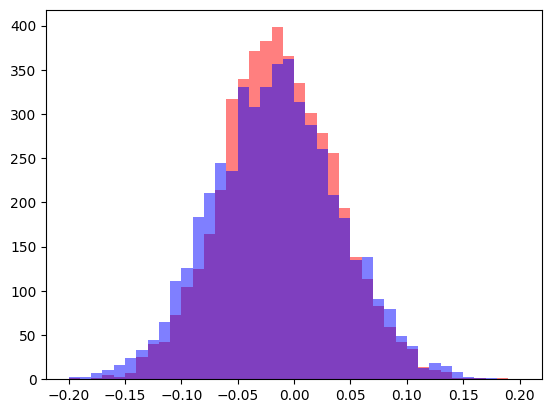

In [21]:
plt.hist(discreps_lv1, bins=np.linspace(-.2,.2,41), alpha=.5, color='red');
plt.hist(discreps_lv0, bins=np.linspace(-.2,.2,41), alpha=.5, color='blue');

Histogram above shows that we are closer to the Las Vegas model after adding in the lineup features

In [22]:
np.mean(np.abs(discreps_lv1)), np.mean(np.abs(discreps_lv0))

(0.04175654640375381, 0.046900118005755706)

Let's look at whether we get better predictions by making a weighted average of our model and the Las Vegas probs

In [23]:
weak_model_preds = d8['preds_test']
strong_model_preds = d1['preds_test']

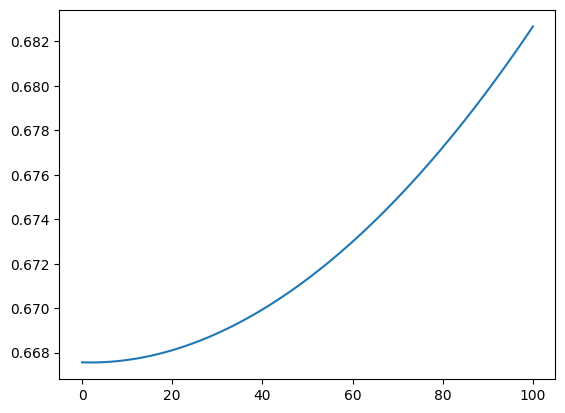

In [24]:
## Mixing in our first (very simple) model
ll_mix_vec_weak = [log_loss(y_test, (k*weak_model_preds+(1-k)*df_test.implied_prob_h_mid)) for k in np.linspace(0,1,101)]
plt.plot(ll_mix_vec_weak)

In [25]:
ll_mix_vec_weak[0] - np.min(ll_mix_vec_weak), np.argmin(ll_mix_vec_weak)

(5.910794778962725e-06, 2)

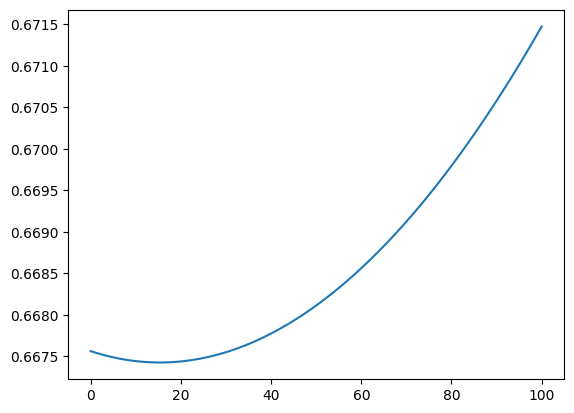

In [26]:
## Mixing in our latest model
ll_mix_vec_strong = [log_loss(y_test, (k*strong_model_preds+(1-k)*df_test.implied_prob_h_mid)) for k in np.linspace(0,1,101)]
plt.plot(ll_mix_vec_strong)

In [27]:
ll_mix_vec_strong[0] - np.min(ll_mix_vec_strong), np.argmin(ll_mix_vec_strong)

(0.00013667134801409464, 15)

In [28]:
# Simulate different model variations on a single test set
# Gives a sense of how much different models (each with the same quality)
# will vary
def ll_model_discrep_shuffle(probvec_true, discreps, num_trials, answers):
    # sim_outcome = np.random.binomial(n=1, p=probvec_true)
    llvec_mod = np.zeros(num_trials)
    discr1 = discreps.copy()
    for i in range(num_trials):
        np.random.shuffle(discr1)
        pv_mod = pv_true  + discr1
        llvec_mod[i] = log_loss(answers, pv_mod)
    return(llvec_mod)

In [29]:
pv_true = df_test.implied_prob_h_mid
losses = ll_model_discrep_shuffle(pv_true, discreps_lv1, 10000, y_test)

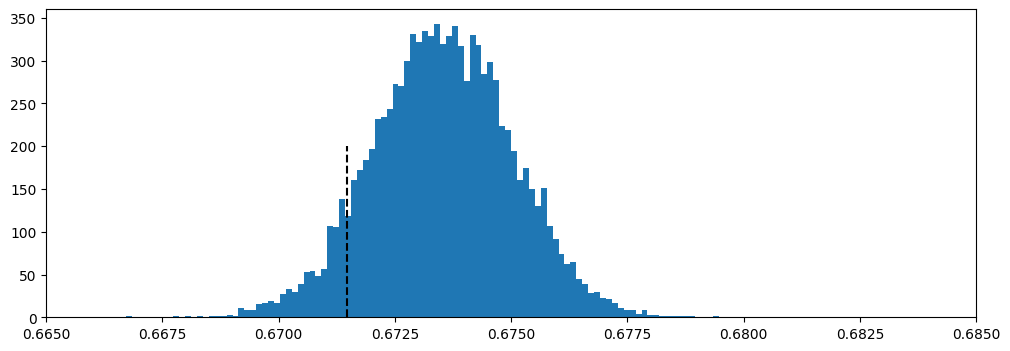

In [30]:
plt.figure(figsize=(12,4))
plt.hist(losses, bins=100);
plt.xlim([.665,.685]);
plt.vlines(x=log_loss(y_test, strong_model_preds), ymin=0, ymax=200, color='k', linestyle='--')

Conclusions

    - We went from ~40bps to ~30bps by adding lineup variables OBS, SLG (for home and away)

    - Changing variants, adding more variables did not seem to improve at all

    - Vegas model is still better overall, but evidence that our model captures effects that they don't

Next Steps

    - Want to model runs scored 
        
        -- will certainly be useful for predicting the over / under
        
        -- may also prove useful for predicting the winner of the game

    - Will want to use probabilistic regression to get a distribution on the runs scored rather than a point estimate